In [31]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import seaborn as sns
import networkx as nx
from networkx.algorithms import approximation as nx_approx


# Adding path to module
sys.path.append("../")
# picture path
PICS = '../pics/'

# Module imports
from contagion import Contagion, config
from contagion.config import _baseconfig
from contagion.plotting import plot_infection_history

In [32]:
my_config = dict(_baseconfig)
my_config["general"]["random state seed"] = 3
my_config["general"]["track graph history"] = True
my_config["general"]["debug level"] = 50
my_config["population"]["population class"] = "NetworkXPopulation"
my_config["population"]["store population"] = True
my_config["population"]["re-use population"] = False
my_config["scenario"]["sim_length"] = 1000
my_config['infection']['infected'] = 10
my_config['infection']["hospitalization probability pdf"]['mean'] = 0.0001
my_config['infection']["hospitalization probability pdf"]['sd'] = 0.00001
my_config['infection']['will have symptoms prob pdf']['mean'] = 0.5
my_config['infection']['will have symptoms prob pdf']['sd'] = 0.1
my_config["population"]["random interactions pdf"]["mean"] = 0.001
my_config["population"]["random interactions pdf"]["sd"] = 0.001
my_config["population"]["random interactions intensity pdf"]["mean"] = 0.0001
my_config["population"]["random interactions intensity pdf"]["sd"] = 0.0001

my_config["population"]["population size"] = 10000
my_config["population"]["nx"]["func"] = "lfr_ba"
my_config["population"]["nx"]["kwargs"] = {
                "m": 5,
                "tau": 1.2,
                "mu": 0.1,
                "min_community": 10,
                "max_community": 500,
                "max_iters": 2000,
                "tolerance": 0.1
            }


In [3]:
#contagion = Contagion(my_config)
my_config["population"]["store_population"] = False
my_config["population"]["re-use population"] = False

In [28]:
class ParScan(object):
    def __init__(self, conf):
        self._conf = conf
        self._par_range = None
        
    def par_update(self, val):
        pass
    
    def __iter__(self):
        for par in self._par_range:
            yield self.par_update(par)

class ScanRndIntRate(ParScan):
    
    def __init__(self, conf, n_rnd_ctc=5):
        super().__init__(conf)
        self._par_range = [1E-5, 0.01, 0.1, 1, 5, 10]
        self._n_rnd_ctc = n_rnd_ctc
        
    def par_update(self, par):
        conf = dict(self._conf)
        
        r_int_per_day = par
                
        conf["population"]["random interactions pdf"]["mean"] = self._n_rnd_ctc
        conf["population"]["random interactions pdf"]["sd"] = np.sqrt(self._n_rnd_ctc)
        conf["population"]["random interactions intensity pdf"]["mean"] = r_int_per_day / self._n_rnd_ctc
        conf["population"]["random interactions intensity pdf"]["sd"] = np.sqrt(r_int_per_day / self._n_rnd_ctc)
        return conf
    
class ScanRndIntNumConstRate(ParScan):
    
    def __init__(self, conf, r_int_per_day=5):
        super().__init__(conf)
        self._par_range = [1, 3, 5, 10, 50]
        self._r_int_per_day = r_int_per_day
        
    def par_update(self, par):
        conf = dict(self._conf)
        
        n_rnd_ctc = par
        r_per_ctc = self._r_int_per_day / par
                
        conf["population"]["random interactions pdf"]["mean"] = n_rnd_ctc
        conf["population"]["random interactions pdf"]["sd"] = np.sqrt(n_rnd_ctc)
        conf["population"]["random interactions intensity pdf"]["mean"] = r_per_ctc
        conf["population"]["random interactions intensity pdf"]["sd"] = np.sqrt(r_per_ctc)
        return conf
    
class ScanRndIntIntConstRate(ParScan):
    
    def __init__(self, conf, r_int_per_day=5):
        super().__init__(conf)
        self._par_range = [1, 3, 5, 10, 50]
        self._r_int_per_day =  r_int_per_day
        
    def par_update(self, par):
        conf = dict(self._conf)
        
        r_per_ctc = par
        n_rnd_ctc = self._r_int_per_day / par
        
        conf["population"]["random interactions pdf"]["mean"] = n_rnd_ctc
        conf["population"]["random interactions pdf"]["sd"] = np.sqrt(n_rnd_ctc)
        conf["population"]["random interactions intensity pdf"]["mean"] = r_per_ctc
        conf["population"]["random interactions intensity pdf"]["sd"] = np.sqrt(r_per_ctc)
        return conf
    
    

In [6]:
scan = ScanRndIntRate(my_config)
all_results_rnd_int_rate = []
for conf in scan:
    results = []
    for i in range(10):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results_rnd_int_rate.append(results)

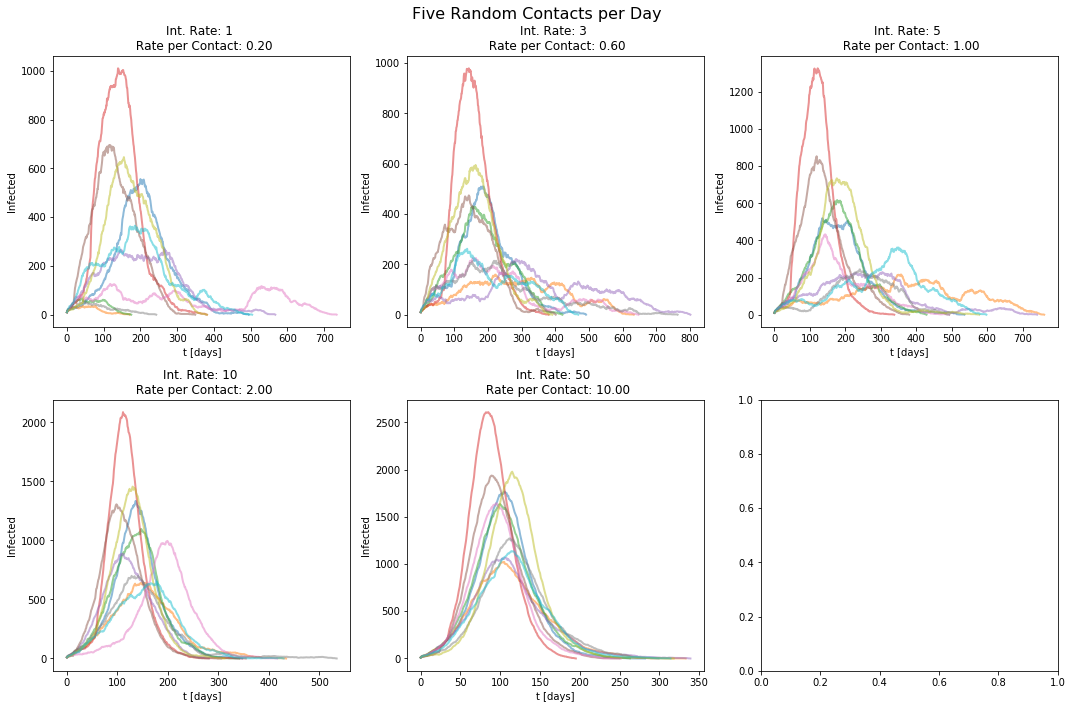

In [25]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
for results, ax, scan_par in zip(all_results_rnd_int_rate, axs.ravel(), scan._par_range):
    for res, _ in results:
        ax.plot(np.arange(len(res['is_infected'])), res['is_infected'],
                lw=2, alpha=0.5)
#ax.set_yscale("log")
        ax.set_xlabel("t [days]")
        ax.set_ylabel("Infected")
        ax.set_title("Int. Rate: {} \n Rate per Contact: {:.2f}".format(scan_par, scan_par/5))
fig.suptitle("Five Random Contacts per Day", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(PICS + "lfr_par_scan_rnd_int_rate_5_rnd_ctc.png", dpi=150)

In [8]:
scan = ScanRndIntNumConstRate(my_config)
all_results_n_rnd_ctc_rate5 = []
for conf in scan:
    results = []
    for i in range(10):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results_n_rnd_ctc_rate5.append(results)

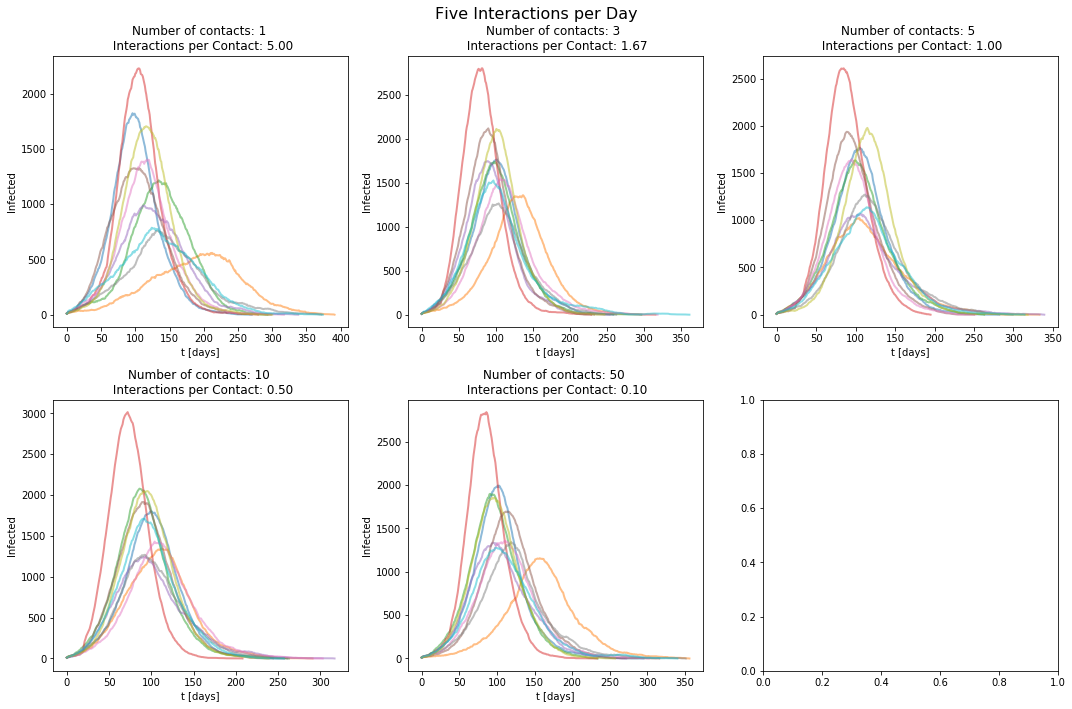

In [26]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
for results, ax, scan_par in zip(all_results_n_rnd_ctc_rate5, axs.ravel(), scan._par_range):
    for res, _ in results:
        ax.plot(np.arange(len(res['is_infected'])), res['is_infected'],
                lw=2, alpha=0.5)
#ax.set_yscale("log")
        ax.set_xlabel("t [days]")
        ax.set_ylabel("Infected")
        ax.set_title("Number of contacts: {} \n Interactions per Contact: {:.2f}".format(scan_par, 5/scan_par))
fig.suptitle("Five Interactions per Day", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(PICS + "lfr_par_scan_n_rnd_ctc_5rnd_ctc.png", dpi=150)

In [29]:
scan = ScanRndIntIntConstRate(my_config)
all_results_n_rnd_int_rate5 = []
for conf in scan:
    results = []
    for i in range(10):
        conf["general"]["random state seed"] =  i
        contagion = Contagion(conf)
        g = contagion.pop._graph
        contagion.sim()
        results.append((pd.DataFrame(contagion.statistics), g))
    all_results_n_rnd_int_rate5.append(results)

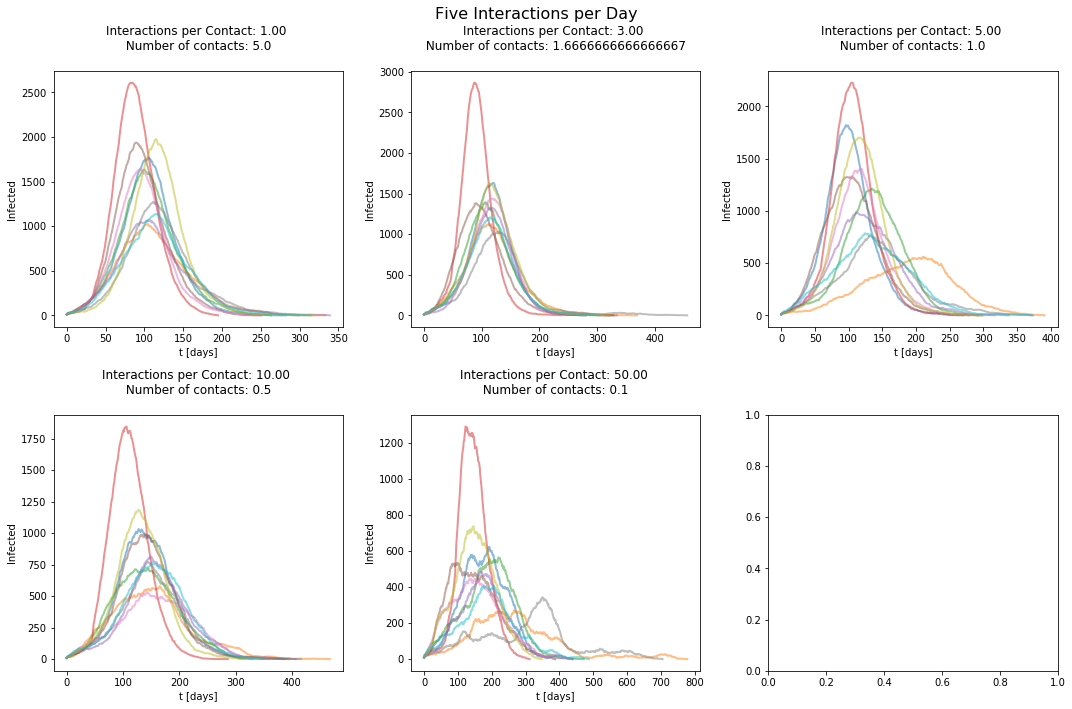

In [30]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
for results, ax, scan_par in zip(all_results_n_rnd_int_rate5, axs.ravel(), scan._par_range):
    for res, _ in results:
        ax.plot(np.arange(len(res['is_infected'])), res['is_infected'],
                lw=2, alpha=0.5)
#ax.set_yscale("log")
        ax.set_xlabel("t [days]")
        ax.set_ylabel("Infected")
        ax.set_title("Interactions per Contact: {:.2f} \n Number of contacts: {} \n".format(scan_par, 5/scan_par))
fig.suptitle("Five Interactions per Day", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(PICS + "lfr_par_scan_n_rnd_int_5rnd_ctc.png", dpi=150)